# PCA Statistical Arbitrage

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *

### What we will learn:
- Building a PCA manually
- Conduct a pairs-trading backtest using PCA
- Simulation of multiple cointegrated assets
- Sector statistical arbitrage using PCA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
import pickle
%matplotlib inline

/home/tom/anaconda3/envs/tribo/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/tom/anaconda3/envs/tribo/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Short recap: cointegration versus correlation

- Cointegrated price series do not necessarily have to be correlated and vice-versa 

- Drunk and her dog: https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction

- Same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)


Engel-Granger Causality

### Principal Component Analysis (PCA) to find structure in complex systems
https://systematicedge.wordpress.com/2013/06/02/principal-component-analysis-in-portfolio-management/

- Unsupervised machine learning.
- "Principal components" are "modes" of a system, similar to vibrational overtones of a guitar string.
- They are eigenvectors of the covariance matrix.
- Number of eigenvectors equals the number of features.
- "Dimensionality reduction": reducing the number of eigenvectors.
- Eigenvectors are "orthogonal" - uncorrelated.

To illustrate this, let's produce two correlated time series:

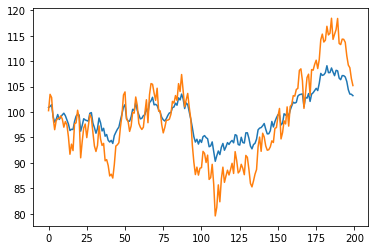

In [2]:
# Create a random seed for consistency
np.random.seed(20)

# Produce a series as the cumulative sum of normally distributed random numbers.
x = np.cumsum(np.random.randn(200)) + 100

# Produce a second series with the same behaviour but higher standard deviation.
y = x*2 + np.random.randn(200) - 100

# Generate an array to be used in our PCA calculation.
# Note that we have to de-mean our values first.
R = np.array([x-np.mean(x),y-np.mean(y)])

# Plot x and y
plt.plot(x)
plt.plot(y)

For PCA we calculate the covariance matrix of R and subsequently the eigenvectors and eigenvalues. Here, the eigenvectors tell us the axis of the largest variance and the eigenvalues tell us the magnitude of the variance along each axis.

In [3]:
# Calculate the covariance matrix
S = np.cov(R)
print('Cov Matrix:', S)

# Calculate the eigenvalues and eigenvectors
EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])

Cov Matrix: [[17.01547369 33.69556579]
 [33.69556579 67.62804956]]
Eigenvalues:  [ 0.18152713 84.46199612]
Eigenvectors:  [[-0.89457408 -0.4469197 ]
 [ 0.4469197  -0.89457408]]


Now we create the vectors in space and plot our x and y values. We can see that we are capturing the direction of the largest variance. These vectors are called "principal components".

In [4]:
# Extract the eigenvectors from EIG
EV = EIG[1]

# Create x-values for plotting eigenvectors
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

# Create y-values for plotting eigenvectors

yy1 = (EV[1][0]/EV[0][0])*xx
yy2 = (EV[1][1]/EV[0][1])*xx

The most significant eigenvector is the one with the highest eigenvalue. Here we extract its row number.

In [5]:
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)

Most significant factor:  1


Now we plot our de-meaned price values along with their priciple components.

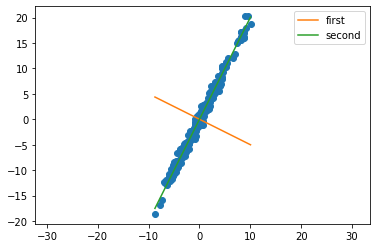

In [6]:
# Plot de-meaned x - y correlation
plt.plot(R[0,:],R[1,:],'o')

# Plot the first principal component
plt.plot(xx,yy1,label='first')

# Plot the second principal component
plt.plot(xx,yy2,label='second')

plt.legend()

# Make sure axis are equal to illustrate orthogonality
plt.axis('equal');

We can see that for the two-dimensional case we get exactly two principal components. With the priciple components we can now calculate our abstract factors:

In [7]:
# Calculating the factor values from the eigenvector
factors = np.dot(EV.T,R)

The plot below shows how well our factors are correlated with x and y. Note that for each return curve we have two factors.
We can see that component 1 with an eigenvalue of 84.46 has a strong correlation with x and y, component 0 with an eigenvalue of only 0.18 does not.

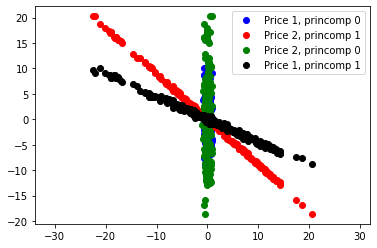

In [8]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();

### PCA Pairs Trade

- The use of PCA for pairs trading and subsequent generalisation of the technique to large portfolios.
- Produce pair of cointegrated price series.
- Build a backtest.
- Analyse the results.

First we create an algorithm for "drunk and dog" cointegration. Here,
- T are the starting values
- Sigma are the standard deviations of each path.
- c is a variable that determines how strongly both returns are connected.
- if c[0] = 0 and c[1] = 0 -> both are random walks (drunk does not own dog).
- if one c is zero and the other non-zero there is a one way causality (drunk owns dog).
- if both c are non-zero there is two-way causality (dog sometimes pulls drunk).

In [9]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

When plotting X and Y we can see that they follow each other closely.
Now, vary c as follows and observe what happens:
- c = [ 0.9, 0.0 ]
- c = [ 0.1, 0.1 ]
- c = [ 0.1, 0.9 ]
- c = [ 0.0 , 0.0]

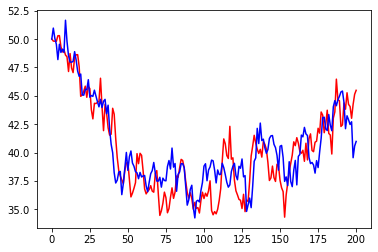

In [10]:
np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

Assessing the quality of our cointegration:
- Critical values for 0.1, 0.05 and 0.01.
- T-statistic should be below crit.

In [11]:
crit = coint(X,Y)
print('Critical Values:',crit[2])
print('T-statistic:',crit[0])
print('P-value:',crit[1])

Critical Values: [-3.95203768 -3.36685108 -3.065724  ]
T-statistic: -5.574176718429721
P-value: 1.2687688654668363e-05


### Application of PCA to pairs trading:
- Use the sklearn PCA package to generate components.
- Linear regression with the price data.
- Z-score the residual to normalise for varying price levels and volatility.
- Trade when residual sufficiently deviates from mean. 
- Use of log prices can help to mitigate large price swings (e.g. in penny stocks)

Below the code for the PCA pairs trade:

In [12]:
def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

def run_pca(pr,components=1,log_prices=True):
    
    # Instanciate PCA 
    pca = PCA(n_components=components)
    px = pr.T-np.mean(pr.T)
    
    if log_prices:
        
        # Calculate the priciple components using log prices
        comps = pca.fit(np.log(pr.T)).components_.T
        
        # Create the factors from the pricinple components
        factors = sm.add_constant(pr.T.dot(comps))
        
    else:
        
        # Calculate the N priciple components using normal prices
        comps = pca.fit(px).components_.T
        
         # Create the factors from the pricinple components
        factors = sm.add_constant(px.dot(comps))  
        

    
    # Regress each factor with the actual underlying prices
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    
    # Calculate the residuals
    resids = list(map(lambda x: x.resid, mm))
    
    return resids, factors

- Running the PCA we can now see the factors with equal values of opposite sign.
- Same as in "regular" pairs trade where opposite sign is expressed by long/short.
- PCA gives reversible results when X and Y are switched, linear regression does not.

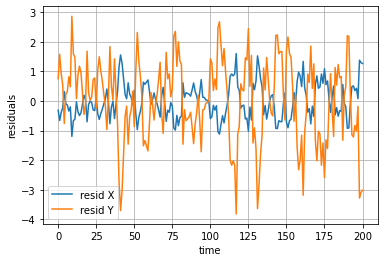

In [13]:
# Create input array from cointegrated price series
R = np.array([X,Y,X])

# Run the PCA calculation
residuals, factors = run_pca(R,log_prices=True)

# Plot the residuals
plt.plot(residuals[0],label='resid X')
plt.plot(residuals[1],label='resid Y')
plt.xlabel('time')
plt.ylabel('residuals')
plt.legend()
plt.grid()

As a side-node, observe that linear regression is not reversible.
- Residuals are calculated as distances to fitting line along to y-axis.
- In PCA residuals are calculated orthogonal to principal component.

In [14]:
m = np.polyfit(X,Y,1)[0]
m_rev = np.polyfit(Y,X,1)[0]
print('Slope of regression:',m)
print('Inverse slope of reverse regression:',1/m_rev)

Slope of regression: 0.7978929779688259
Inverse slope of reverse regression: 1.0528140853084136


### Pairs-Trade Backtest
- Sequentially step through time and instruments.
- Calculate if z-score of residuals is large enough to trade.
- If in trade, see if residuals have mean reverted enough to exit.
- Calculate the pnl.

(For simplicity we calculate the residuals first, thus introducing a forward-looking bias. This is to make the calcs faster and it is rectified later.)

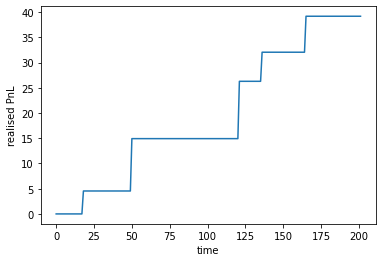

In [15]:
inpos = np.zeros(R.shape[0]) # side: long=+1; short=-1
pnl = [0] # PnL vector
bw = 2 # z-score threshold (bandwidth)
op = {} # dict of entry prices

# loop through time steps
for i in range(len(residuals[0])):
    p = 0 # initialise pnl-calc for a particular time step
    
    # loop through instruments
    for inst in range(R.shape[0]):
        
        # calculate the z-score of residuals
        zs = Zscore(residuals[inst])[i]
        
        # Entry condition: z-score above bandwith and no position on
        if np.abs(zs)>bw and inpos[inst] == 0:
            op[inst] = R[inst,i] # record the open price
            inpos[inst] = zs  # tell algo that we have a position
            
        # Exit condition: z-score has crossed zero and position on
        elif zs*np.sign(inpos[inst])<0:
            
            # Calculate pnl as (exit-entry)*side
            p+=((-R[inst,i]+op[inst])*np.sign(inpos[inst]))
            inpos[inst] = 0 # set side to zero
    
    # append the new pnl to vector
    pnl.append(p)
    
# Plot the results of the backtest
plt.plot(np.cumsum(pnl),'-')
plt.xlabel('time')
plt.ylabel('realised PnL')
plt.show()

### Simulate sector cointegration

- Simulated time series provide understandable results. 
- Stocks within a sector are often cointegrated.
- Maths of "Drunk and her dog" generalisation shown below:

\begin{align}
c_{ij} = \Bigg\{ 
\begin{split}
-a_{ij} \quad for \quad i \leq j \\ 
a_{ij} \quad for \quad i \geq j \\ 
-a_{ij} \quad for \quad i = j
\end{split}
\end{align}

\begin{align}
X_{t}^{(i)}-X_{t-1}^{(i)} = \sum_{j} c_{ij} X_{t-1}^{(j)} + \epsilon_{i} \quad with \quad a_{ij} \geq 0
\end{align}

- *X* denotes the time series, *c* is the causality matrix.
- *a* are the positive elements of the causality matrix. 

(Note that the *a's* denote the relationships between different series. We can simply use random numbers to start with. As we increase the number of series, we need to keep *a* small to avoid positive feedback scenarios.) 

Below the code that implements the above equations.

In [16]:
def make_coint_1(N,steps,a=0.1):
    X = [np.zeros(N)]
    
    # Create the causality matrix
    c = (np.tril(np.ones(N))-np.triu(np.ones(N))-np.diag(np.ones(N),0))*a #c = np.random.rand(N,N)*0.1

    # loop through time steps
    for i in range(steps):
        
        # Calculate the returns for each time series
        rx = (np.sum(c*X[-1],axis=1)+np.random.randn(N))
        
        # Add the new return to the last price of the time series
        X.append(X[-1]+rx)
        
    # return array of all series
    return np.array(X).T

Let's create a cointegrated pair with this technique.

__Play with this by varying *a* and observe the results.__

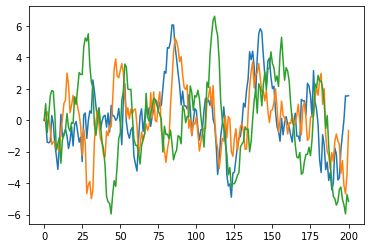

In [17]:
np.random.seed(21)
N = 3
a1 = 0.1 # general case
a2=[[0.02,0.1],[0.1,0.02]] # for N = 2
a3=[[0.06,0.04,0.08],[0.06,0.06,0.04],[0.06,0.08,0.04]] # for N = 3
X1 = make_coint_1(N,200,a=a1).T

for i in range(N):
    plt.plot(X1[:,i])

We can see we have produced a set of stationary time series, testing for cointegration we see that most of them are below the critical values.

In [18]:
print('Critical values:',coint(X1.T[0],X1.T[1])[2])
for i in range(X1.T.shape[0]):
    for k in range(i,X1.T.shape[0]):
        if not i==k:
            print('t-stats for coint of series %s and %s:'%(i,k), coint(X1.T[i],X1.T[k])[0])
        

Critical values: [-3.95203768 -3.36685108 -3.065724  ]
t-stats for coint of series 0 and 1: -4.4134504273519495
t-stats for coint of series 0 and 2: -3.750039650509555
t-stats for coint of series 1 and 2: -4.537611349936926


Let's now apply our statistical arbitrage system to a simple long/short pair in order to test if our system is working properly. First, let's produce a cointegrated time series and plot it to confirm its properties.

### PCA Portfolio Trading

- Application of strategy to larger portfolio.
- Careful with the causality coefficients as large numbers of strong cross-dependencies can create positive feedback loops between the series. 
- Larger N - higher to probability of the feedack loops for a given *alpha*.

__Please vary alpha in this exercise and observe how the behaviour of our time series changes.__

In [19]:
#np.random.seed(231)
N = 10
alpha = 0.06
X2 = make_coint_1(N,300,a=np.random.rand(N,N)*alpha) + 50

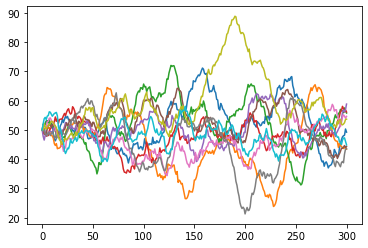

In [20]:
for i in X2:
    plt.plot(i)

### Cumulative explained variance

- 3 principle components explain 75% of variance
- Too many components lead to very high correlation and very small PnL/trade
- Enough PnL/trade to overcome trading costs

Text(0, 0.5, 'Explained Variance')

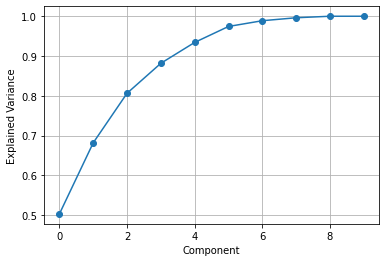

In [21]:
pca = PCA(n_components=10)
pca.fit(np.log(X2))

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_),'-o')
plt.grid()
plt.xlabel('Component')
plt.ylabel('Explained Variance')

- Useful to look at the average t-statistics between all possible pairs.
- High average t-stats - good probability of strategy success.
- Johansen test tends to perform poorly out-of-sample.

In [22]:
# Cointegration test:
coints = []
print('Critical values:',coint(X2[0],X2[1])[2])
for i in range(X2.shape[0]):
    for k in range(i,X2.shape[0]):
        if not i==k:
            coints.append(coint(X2[i],X2[k])[0])
            
print('Average coint t-stats:',np.mean(coints))

Critical values: [-3.93331886 -3.35657281 -3.05861756]
Average coint t-stats: -2.6914524577592713


- Simulated data can give us an understanding how well our backtest performs under idealised conditions. 

- In the next part we are looking at applying this algorithm to real market data using Quantopian.

### Sector-portfolio backtest

There are many strategies we can deploy based on our techniques such as:
- sort the z-scores of our factors and go long the lowest and short the N assets with the highest z-scores. 
- scale the position size of each instrument according to z-score.
- only rebalance portfolio when sum of z-scores exceeds a threshold.

All of them have their uses and they need to be tested on a case-by-case basis. Here, we choose the first example as shown below. This time we eliminate the forward-looking bias by recalculating the residuals at every time step.

In [23]:
mdata = pickle.load(open('marketdata.pick','rb'))

In [24]:
pr = np.array(mdata).T#[:12,:]
max_pos=3
num_factors=3
initial_cash=1e6

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < 50: continue

    # Run the PCA, only on the past prices
    resids, factors = run_pca(pr.T[max([0,i-400]):i],num_factors,log_prices=False)
    zs = {}

    # Calculate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: pass

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/len(pri))/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.
        pnl += (pri[idx]-np.abs(entry[idx]))*pos
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    for idx in idx_long:
        entry[idx] = pri[idx]
    for idx in idx_short:
        entry[idx] = -pri[idx]

    print(i,sum(pnls))

50 0
51 -21.165999999994796
52 -106.57200000000252
53 -83.94700000000546
54 -26.833000000003423
55 -54.27699999999781
56 32.18999999999215
57 53.96399999998951
58 93.02200000001132
59 208.6330000000077
60 215.50800000000203
61 278.09200000000453
62 327.86000000000524
63 235.0630000000118
64 237.25000000000355
65 593.5150000000051
66 561.0220000000104
67 624.5780000000065
68 623.2400000000008
69 686.7020000000095
70 686.9269999999975
71 599.1580000000084
72 824.4550000000012
73 742.5780000000119
74 762.0660000000041
75 804.0080000000016
76 918.5370000000128
77 1008.8470000000062
78 1008.0530000000119
79 1119.1180000000052
80 1161.7720000000252
81 1261.7950000000046
82 1194.2060000000083
83 1377.6350000000086
84 1385.3770000000077
85 1328.324000000004
86 1304.390999999991
87 1324.1520000000141
88 1294.7050000000042
89 1301.8230000000015
90 1361.6370000000024
91 1376.067000000005
92 1275.9090000000215
93 1170.8990000000174
94 1127.4110000000112
95 1240.2160000000083
96 1215.7790000000175


415 995.9310000000316
416 1058.3100000000375
417 872.6590000000358
418 773.9200000000358
419 784.9370000000445
420 758.522000000046
421 804.4940000000411
422 893.5190000000446
423 751.1830000000382
424 895.0080000000439
425 883.6610000000462
426 783.4780000000732
427 812.5030000000708
428 910.6720000000726
429 858.547000000077
430 905.7370000000749
431 835.3680000000634
432 887.5140000000675
433 841.8280000000703
434 828.781000000074
435 919.0260000000682
436 996.1430000000623
437 1052.1480000000724
438 1035.9860000000622
439 981.1520000000597
440 1036.8400000000506
441 1046.3790000000602
442 995.7050000000709
443 943.3740000000685
444 936.4660000000603
445 886.6880000000813
446 921.1590000000758
447 758.104000000071
448 767.0030000000728
449 818.3180000000866
450 868.4570000000853
451 842.1330000000918
452 875.5410000000928
453 781.7360000000979
454 721.658000000101
455 715.81400000011
456 702.0390000001069
457 743.5060000001122
458 718.8580000001139
459 725.9060000001241
460 759.1420

790 -770.3969999997156
791 -824.826999999717
792 -754.1219999997014
793 -868.1249999997151
794 -1045.9739999997066
795 -1083.0209999997192
796 -1053.1819999997067
797 -1073.0189999997153
798 -1186.3739999997208
799 -1233.4299999997145
800 -1159.2449999997175
801 -1204.1469999997012
802 -1062.4929999996925
803 -1262.6209999997072
804 -1045.408999999706
805 -886.1559999996955
806 -958.0069999997074
807 -908.3489999997225
808 -815.3629999997207
809 -944.4379999997327
810 -861.2889999997232
811 -1010.9069999997283
812 -1041.4599999997363
813 -1024.8669999997178
814 -1098.8489999997284
815 -1101.849999999724
816 -1196.9309999997351
817 -1169.3039999997284
818 -1111.2919999997314
819 -1173.3899999997252
820 -1164.23299999972
821 -1171.4459999997193
822 -1098.5209999997192
823 -1041.7269999997268
824 -1124.3009999997412
825 -1049.299999999741
826 -999.9949999997373
827 -908.8639999997413
828 -817.5959999997499
829 -754.3789999997435
830 -672.2719999997245
831 -669.0589999997462
832 -806.60499

KeyboardInterrupt: 

In [ ]:
plt.plot(np.cumsum(pickle.load(open('pnls.pick','rb'))))